In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load from Google Drive or local
df = pd.read_csv("/content/drive/MyDrive/train.csv")  # Change this path if needed

# Show shape and preview
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


In [ ]:
#take only label columns
x = df.iloc[:, 2:].sum()
x

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


In [ ]:
# take label columns and sum it column wise
rowsums = df.iloc[:,2:].sum(axis=1)
rowsums

,0
0,0
1,0
2,0
3,0
4,0
...,...
159566,0
159567,0
159568,0
159569,0


In [ ]:
no_label_count = 0

for i, count in rowsums.items():
  if count == 0:
    no_label_count += 1

print("Total numberof comments:", len(df))
print("Number of comments without any label:", no_label_count)
print("Total labels", x.sum())

Total numberof comments: 159571
Number of comments without any label: 143346
Total labels 35098


<ipython-input-31-1974485a4856>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette="magma")


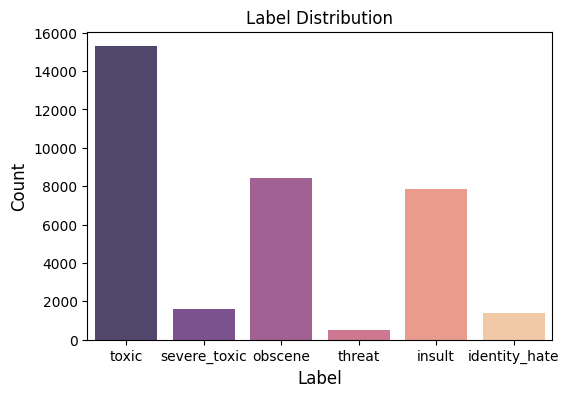

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette="magma")
plt.title("Label Distribution")
plt.ylabel("Count", fontsize=12)
plt.xlabel("Label", fontsize=12)
plt.show()

<ipython-input-32-667491268c9e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="magma")


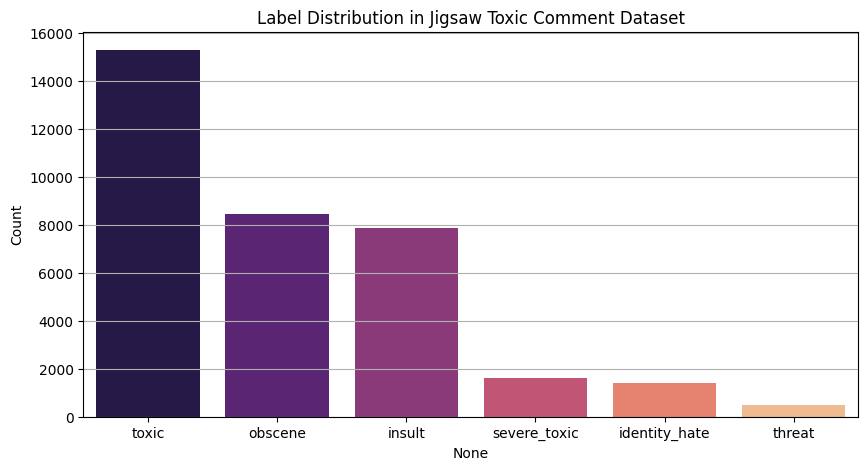

Average number of labels per comment: 0.2199522469621673
Comments with no labels: 143346


In [ ]:
# Check label distribution
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = df[labels].sum().sort_values(ascending=False)

# Plot label distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="magma")
plt.title("Label Distribution in Jigsaw Toxic Comment Dataset")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

# Multi-label statistics
print("Average number of labels per comment:", df[labels].sum(axis=1).mean())
print("Comments with no labels:", (df[labels].sum(axis=1) == 0).sum())


<ipython-input-33-b8430ad8522e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=rowsums.values, alpha=0.8, palette="magma")


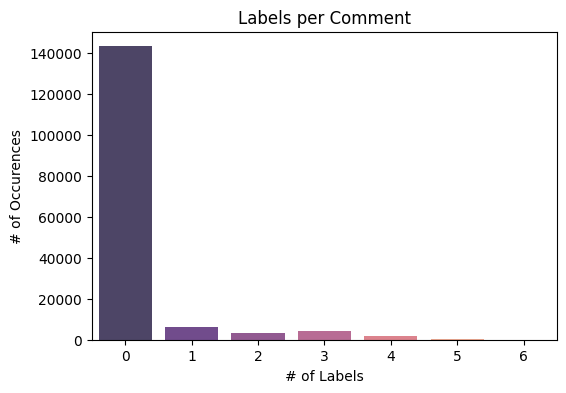

In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=rowsums.values, alpha=0.8, palette="magma")
plt.title('Labels per Comment')
plt.ylabel('# of Occurences')
plt.xlabel('# of Labels')

plt.show()

# **Data Preprocessing**

In [ ]:
# Define text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-letters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    return text

# Apply cleaning
df['clean_comment'] = df['comment_text'].apply(clean_text)
df[['comment_text', 'clean_comment']].head()


,comment_text,clean_comment
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


In [ ]:
df = df.drop(columns=['id'], axis=1)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


In [ ]:
# remove stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return " ".join(no_stopword_text)

# stemming
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
def stemming(sentence):
    stemmed_sentence = ""
    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "

    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [ ]:
df['clean_comment'] = df['clean_comment'].apply(lambda x: remove_stopwords(x))
df['clean_comment'] = df['clean_comment'].apply(lambda x: stemming(x))

In [ ]:
# Vectorize the clean text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['clean_comment'])

# Target labels
y = df[labels]

print("Shape of feature matrix:", X.shape)
print("Shape of target labels:", y.shape)


Shape of feature matrix: (159571, 5000)
Shape of target labels: (159571, 6)


In [ ]:
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression

OneVsRestClassifier does the following:

Trains one logistic regression model for each column of y_train.

Each model learns to predict "yes" or "no" for just one label.

During prediction, it runs all models and combines their results into a full multi-label prediction.

In [ ]:
# Use Logistic Regression with One-vs-Rest strategy for multi-label classification
model = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (Micro):", f1_score(y_test, y_pred, average='micro'))
print("F1 Score (Macro):", f1_score(y_test, y_pred, average='macro'))

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=labels))

Accuracy: 0.9199436001879994
F1 Score (Micro): 0.6863651935594381
F1 Score (Macro): 0.48586555001260107

Classification Report:

               precision    recall  f1-score   support

        toxic       0.90      0.63      0.74      3056
 severe_toxic       0.57      0.25      0.34       321
      obscene       0.91      0.64      0.75      1715
       threat       0.58      0.09      0.16        74
       insult       0.81      0.53      0.64      1614
identity_hate       0.75      0.17      0.27       294

    micro avg       0.87      0.57      0.69      7074
    macro avg       0.76      0.38      0.49      7074
 weighted avg       0.86      0.57      0.68      7074
  samples avg       0.06      0.05      0.05      7074



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-46-5344436f941d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_scores, palette="magma")


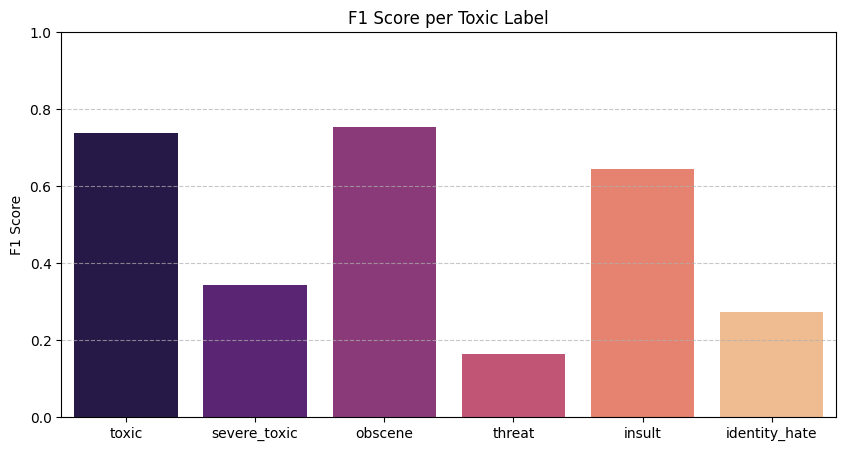

In [ ]:
# F1-score per label
f1_scores = f1_score(y_test, y_pred, average=None)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=f1_scores, palette="magma")
plt.title("F1 Score per Toxic Label")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#SVM

SVM Classifier Results
-----------------------
Accuracy: 0.9196616011279962
F1 Score (micro): 0.7091777887625639
F1 Score (macro): 0.5224041428698168

Classification Report:

               precision    recall  f1-score   support

        toxic       0.88      0.67      0.76      3056
 severe_toxic       0.54      0.22      0.32       321
      obscene       0.89      0.69      0.78      1715
       threat       0.48      0.19      0.27        74
       insult       0.80      0.57      0.66      1614
identity_hate       0.70      0.23      0.34       294

    micro avg       0.85      0.61      0.71      7074
    macro avg       0.72      0.43      0.52      7074
 weighted avg       0.84      0.61      0.70      7074
  samples avg       0.06      0.05      0.06      7074



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-49-a792cc2cbc12>:32: FutureWarning:

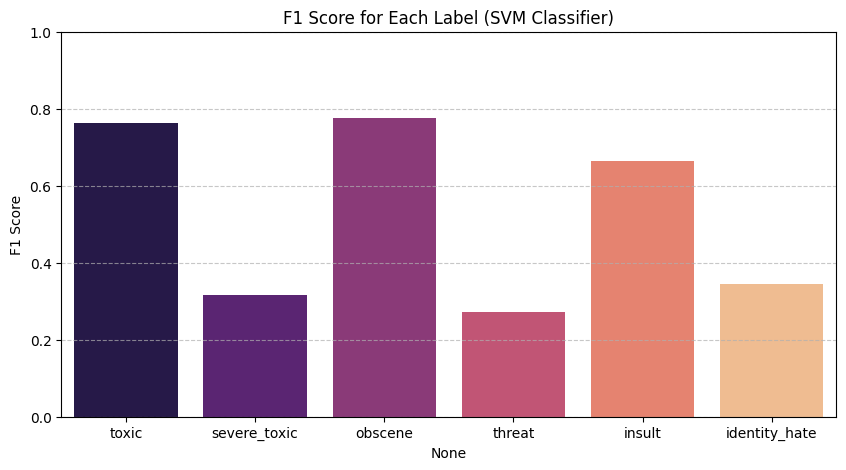

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Define the model
svm_model = OneVsRestClassifier(LinearSVC())

# Train the model
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report, f1_score, accuracy_score

print("SVM Classifier Results")
print("-----------------------")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 Score (micro):", f1_score(y_test, y_pred_svm, average='micro'))
print("F1 Score (macro):", f1_score(y_test, y_pred_svm, average='macro'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_svm, target_names=y.columns))

# Plot F1-scores per label
f1_scores_svm = f1_score(y_test, y_pred_svm, average=None)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=y.columns, y=f1_scores_svm, palette="magma")
plt.title("F1 Score for Each Label (SVM Classifier)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#  Naive bayes


Naive Bayes Accuracy: 0.9132069559768135
Naive Bayes F1 Score (Micro): 0.6108998732572877
Naive Bayes F1 Score (Macro): 0.40377970380509404

Naive Bayes Classification Report:

               precision    recall  f1-score   support

        toxic       0.91      0.52      0.67      3056
 severe_toxic       0.49      0.25      0.33       321
      obscene       0.89      0.53      0.66      1715
       threat       0.00      0.00      0.00        74
       insult       0.81      0.46      0.59      1614
identity_hate       0.44      0.11      0.17       294

    micro avg       0.85      0.48      0.61      7074
    macro avg       0.59      0.31      0.40      7074
 weighted avg       0.83      0.48      0.60      7074
  samples avg       0.05      0.04      0.04      7074



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-50-84778f97d245>:25: FutureWarning:

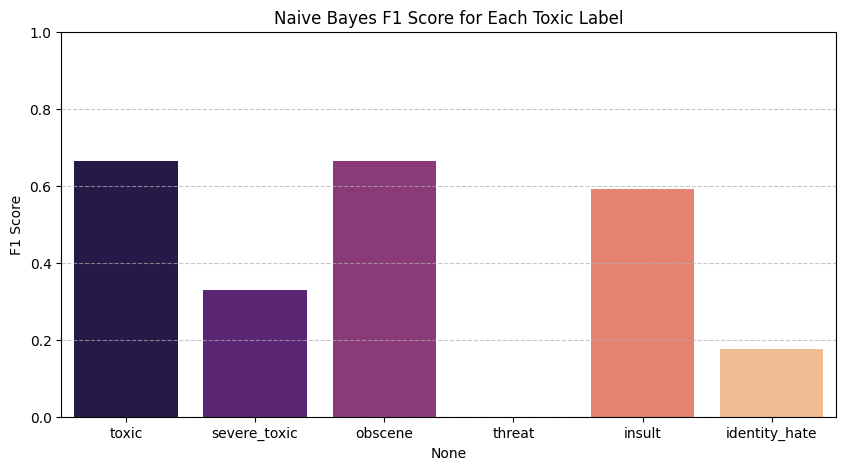

In [ ]:
# Step 1: Import Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

# Step 2: Train Naive Bayes Model
nb_model = OneVsRestClassifier(MultinomialNB())
nb_model.fit(X_train, y_train)

# Step 3: Predict with the trained Naive Bayes model
y_nb_pred = nb_model.predict(X_test)

# Step 4: Evaluate Naive Bayes Model
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_nb_pred))
print("Naive Bayes F1 Score (Micro):", f1_score(y_test, y_nb_pred, average='micro'))
print("Naive Bayes F1 Score (Macro):", f1_score(y_test, y_nb_pred, average='macro'))

print("\nNaive Bayes Classification Report:\n")
print(classification_report(y_test, y_nb_pred, target_names=y.columns))

# Step 5: Visualize F1 Scores for Naive Bayes Model
f1_scores_nb = f1_score(y_test, y_nb_pred, average=None)

plt.figure(figsize=(10, 5))
sns.barplot(x=y.columns, y=f1_scores_nb, palette="magma")

plt.title("Naive Bayes F1 Score for Each Toxic Label")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()